# 1. Preparation
In this section, we will import the necessary libraries and define several functions to preprocess the training data.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O 
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error #For calculating the Root mean squqared error

In [2]:
## for Deep-learing library
import keras
from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from tensorflow.keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

First, We import the data set using pandas. 

In [3]:
df = pd.read_csv('dataset/household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [4]:
df.head()#Let's see a portion of our dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.sample(15)#15 random sample of our dataset

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2008-04-25 07:50:00,1.484,0.094,242.47,6.0,0.0,2.0,19.0
2008-12-25 22:46:00,0.578,0.190,241.09,2.4,0.0,0.0,0.0
2009-02-03 18:54:00,2.386,0.078,240.64,9.8,0.0,0.0,18.0
2008-12-31 23:30:00,0.650,0.208,247.07,2.8,0.0,1.0,0.0
2008-05-02 05:49:00,0.248,0.000,240.40,1.0,0.0,0.0,1.0
2007-12-20 04:31:00,0.216,0.000,246.98,0.8,0.0,0.0,0.0
2010-02-23 17:33:00,0.322,0.070,242.78,1.4,0.0,0.0,1.0
2010-11-16 23:59:00,0.436,0.214,243.69,2.0,0.0,1.0,0.0
2010-07-08 12:21:00,0.256,0.100,241.91,1.2,0.0,0.0,1.0


In [6]:
df.shape #So, in our dataset we have 2075259 rows and 7 columns

(2075259, 7)

### Attribute Information:

1. date: Date in format dd/mm/yyyy
   time: time in format hh:mm:ss
2. global_active_power: household global minute-averaged active power (in kilowatt)
3. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
4. voltage: minute-averaged voltage (in volt)
5. global_intensity: household global minute-averaged current intensity (in ampere)
6. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
7. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
8. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


### Generate descriptive statistics of our dataset
Now, we are want to generate descriptive statistics of our dataset that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

In [8]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### To see, Is there any missing value in our data set?

In [9]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
droping_list_all=[]
for j in range(0, 7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

We have missing value in our dataset, thus we are filling up the missing values with the mean values of the columns 

In [11]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

No handles with labels found to put in legend.


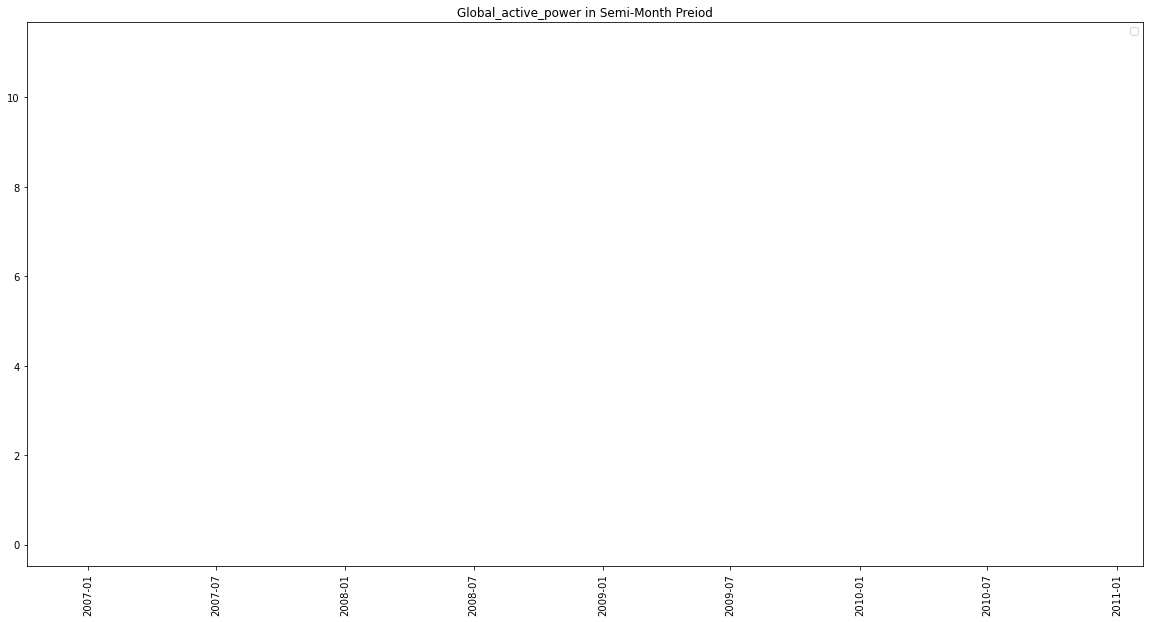

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df['Global_active_power'],linestyle = '-')
plt.xticks(rotation=90)
plt.title ('Global_active_power in Semi-Month Preiod')
plt.legend()
plt.show()

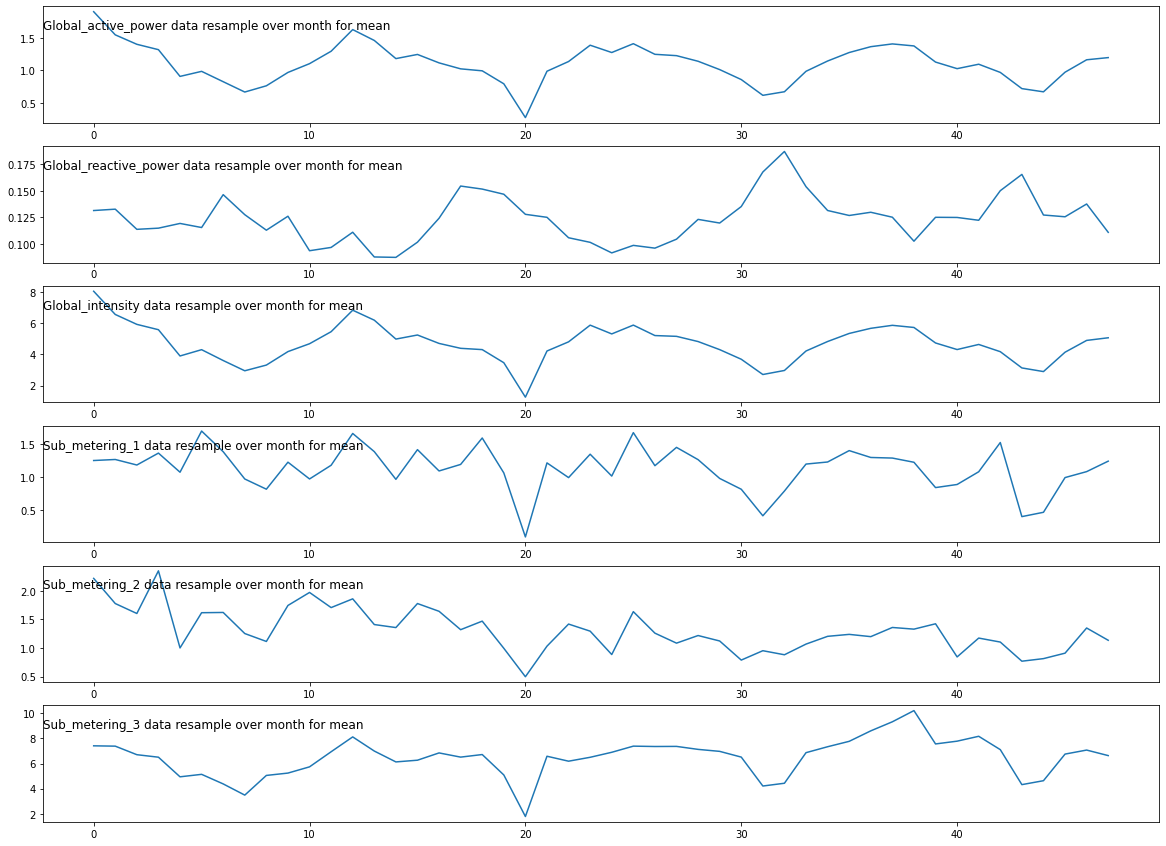

In [13]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 15))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

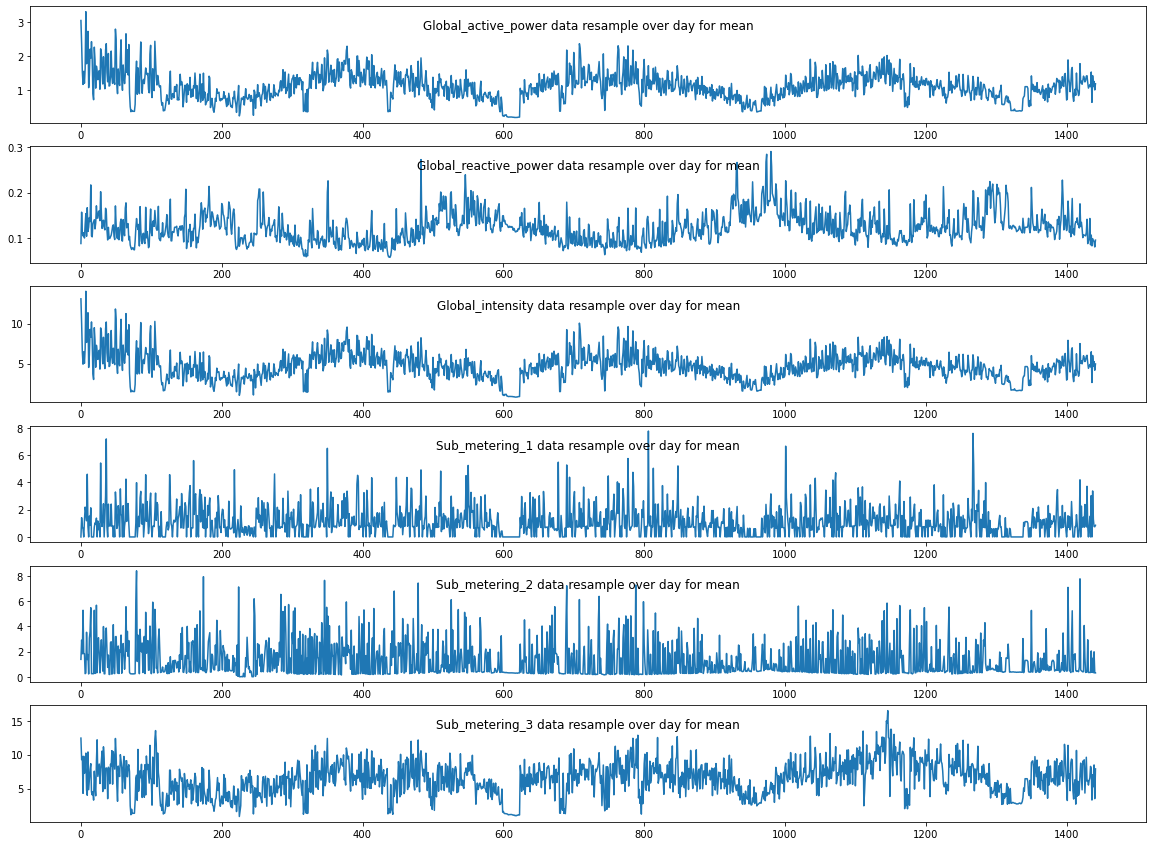

In [14]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 15))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

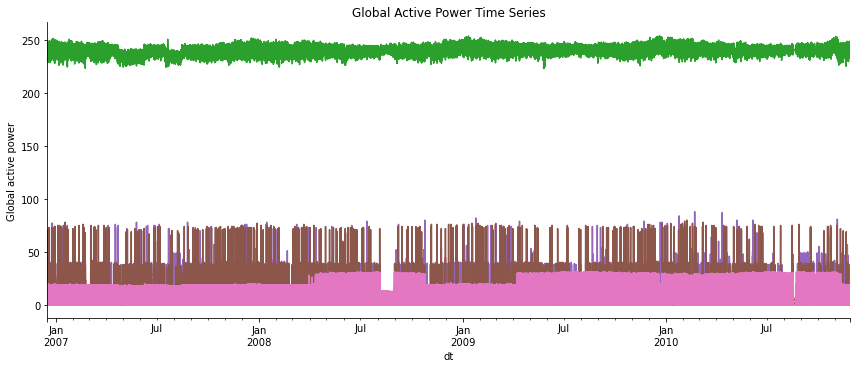

In [15]:
df.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

Text(0.5, 1.0, 'Monthly resampling')

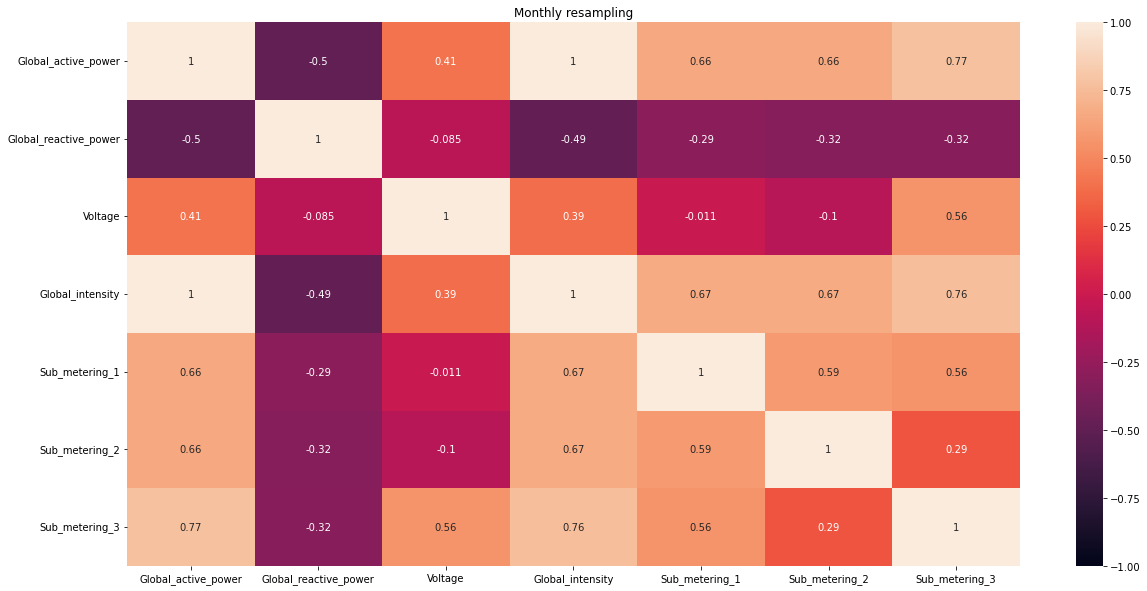

In [16]:
plt.figure(figsize=(20,10))
dfm = df.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

Text(0.5, 1.0, 'Daily resampling')

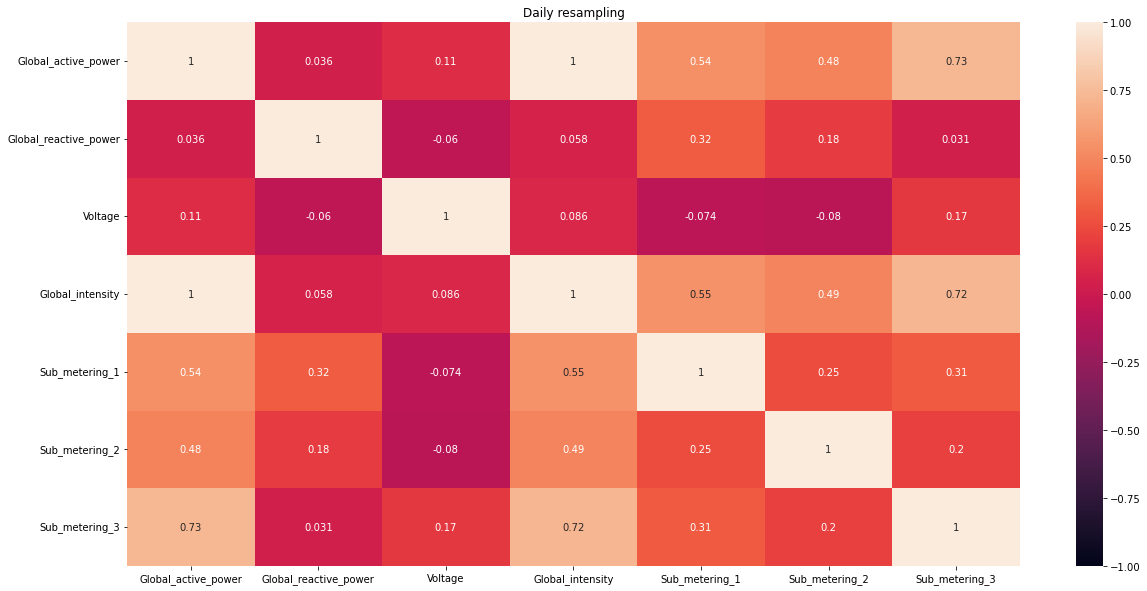

In [17]:
plt.figure(figsize=(20,10))
df_daily = df.resample('D').mean()
sns.heatmap(df_daily.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)

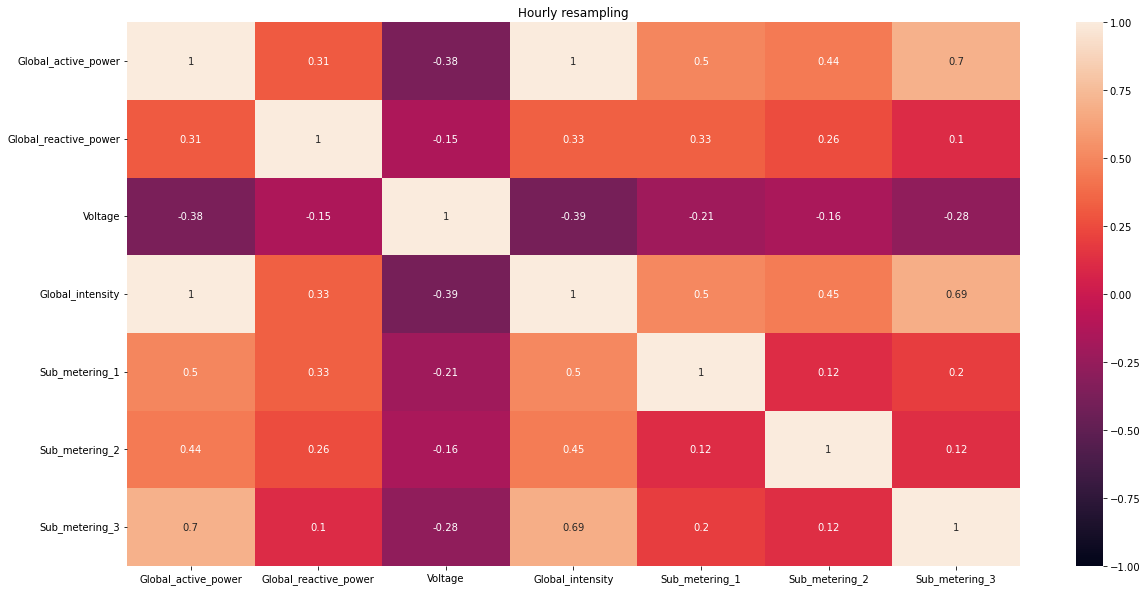

In [18]:
plt.figure(figsize=(20, 10))
df_hour = df.resample('H').mean()
sns.heatmap(df_hour.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

# 2. Predicting the Global Active Power

In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [20]:
df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [21]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.205723,0.455597


In [67]:
values = reframed.values
n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [68]:
#define Model
model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(70, return_sequences=False),)
model.add(Dense(25))
model.add(Dropout(0.35))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam',)
# fit network
history = model.fit(train_x, train_y, epochs=150, batch_size=60, 
validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/150
146/146 - 5s - loss: 0.0185 - val_loss: 0.0120 - 5s/epoch - 33ms/step
Epoch 2/150
146/146 - 1s - loss: 0.0123 - val_loss: 0.0100 - 1s/epoch - 10ms/step
Epoch 3/150
146/146 - 2s - loss: 0.0119 - val_loss: 0.0097 - 2s/epoch - 11ms/step
Epoch 4/150
146/146 - 2s - loss: 0.0116 - val_loss: 0.0098 - 2s/epoch - 11ms/step
Epoch 5/150
146/146 - 2s - loss: 0.0113 - val_loss: 0.0095 - 2s/epoch - 10ms/step
Epoch 6/150
146/146 - 1s - loss: 0.0112 - val_loss: 0.0099 - 1s/epoch - 10ms/step
Epoch 7/150
146/146 - 2s - loss: 0.0112 - val_loss: 0.0097 - 2s/epoch - 12ms/step
Epoch 8/150
146/146 - 1s - loss: 0.0111 - val_loss: 0.0098 - 1s/epoch - 10ms/step
Epoch 9/150
146/146 - 1s - loss: 0.0111 - val_loss: 0.0095 - 1s/epoch - 8ms/step
Epoch 10/150
146/146 - 1s - loss: 0.0109 - val_loss: 0.0099 - 1s/epoch - 9ms/step
Epoch 11/150
146/146 - 1s - loss: 0.0110 - val_loss: 0.0098 - 1s/epoch - 10ms/step
Epoch 12/150
146/146 - 1s - loss: 0.0109 - val_loss: 0.0096 - 1s/epoch - 9ms/step
Epoch 13/150
146

In [69]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 128)            69632     
                                                                 
 lstm_19 (LSTM)              (None, 70)                55720     
                                                                 
 dense_26 (Dense)            (None, 25)                1775      
                                                                 
 dropout_13 (Dropout)        (None, 25)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 127,153
Trainable params: 127,153
Non-trainable params: 0
_________________________________________________________________


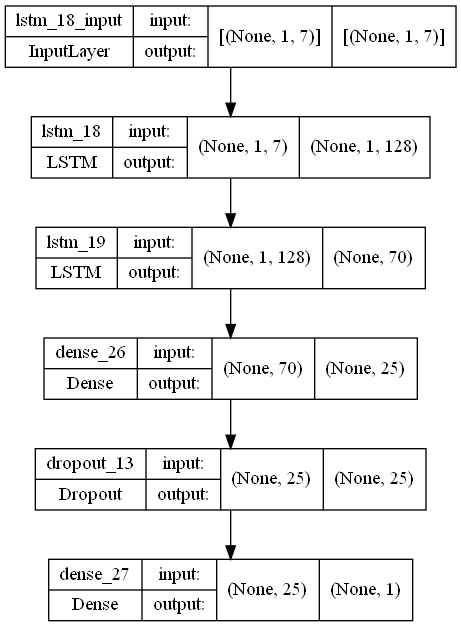

In [70]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

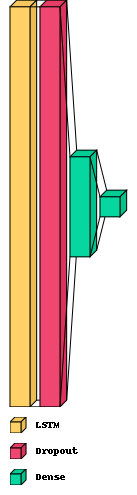

In [58]:
import visualkeras
visualkeras.layered_view(model,legend=True)

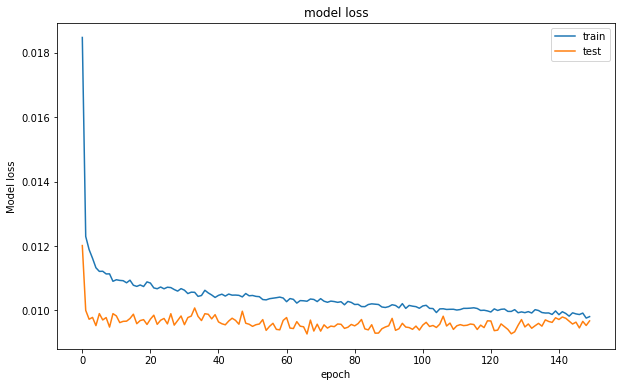

In [74]:
# summarize history for loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [72]:
# make a prediction
est_y = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((est_y, test_x[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.633


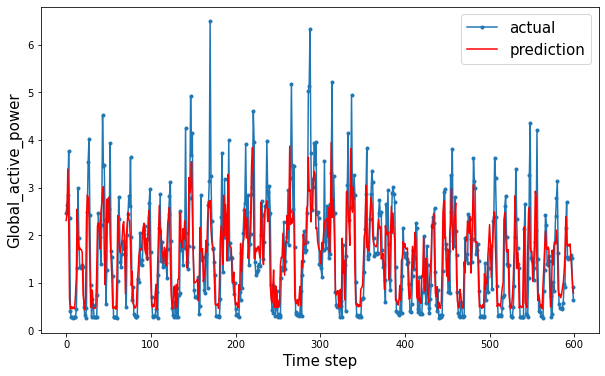

In [73]:
range_len=600
plt.figure(figsize=(10, 6))
x_range=[x for x in range(range_len)]
plt.plot(x_range,inv_y[:range_len], marker='.', label="actual")
plt.plot(x_range, inv_yhat[:range_len], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()